In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imshow
from sklearn.decomposition import PCA


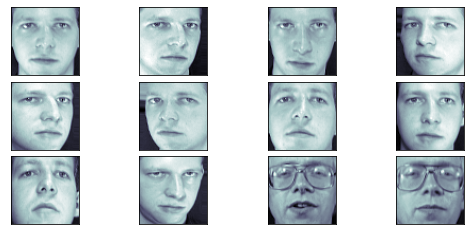

In [2]:
# load dataset.
faces_image = np.load('olivetti_faces.npy')

# show dataset.
fig, axes = plt.subplots(3, 4, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(faces_image[i], cmap='bone')

400 64 64


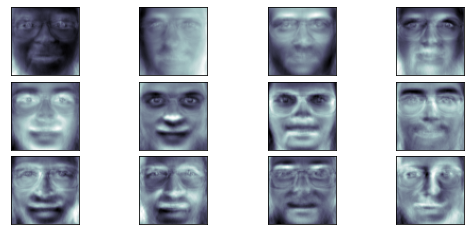

In [3]:
# use PCA to do face dimensionality reduction.
n_components = 150
def face_pca(faces, n_components):
    '''
    利用 sklearn 的 PCA 进行图像降维
    faces: 人脸数据集，faces[i] 为一张 64*64 的图片
    n_components: 选择多少个主成分
    return: pca以后的人脸数据，特征脸
    '''
    h = faces.shape[1]
    w = faces.shape[2]
    print(faces.shape[0], faces.shape[1], faces.shape[2])
    
    faces_data = faces.reshape(faces.shape[0], h*w)
    
    pca = PCA(n_components = n_components).fit(faces_data)
    
    faces_pca = pca.transform(faces_data)
    eigen_faces = pca.components_.reshape((n_components, h, w))
    
    return faces_pca, eigen_faces

# 特征脸：eigen_faces
faces_pca, eigen_faces = face_pca(faces_image, n_components)

# faces_data: 400x4096
# eigen_data: 150x4096
# faces_pca: 150x4096
                
# Show eigen faces
fig, axes = plt.subplots(3, 4, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigen_faces[i], cmap='bone')

<ipython-input-5-807646eabbee>:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, num, figsize=(4 * num, 4),


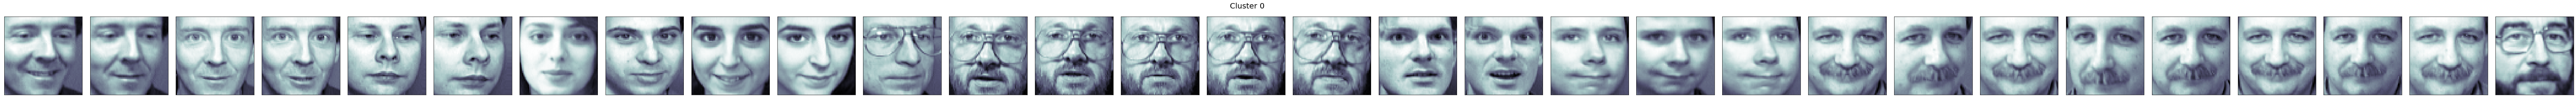

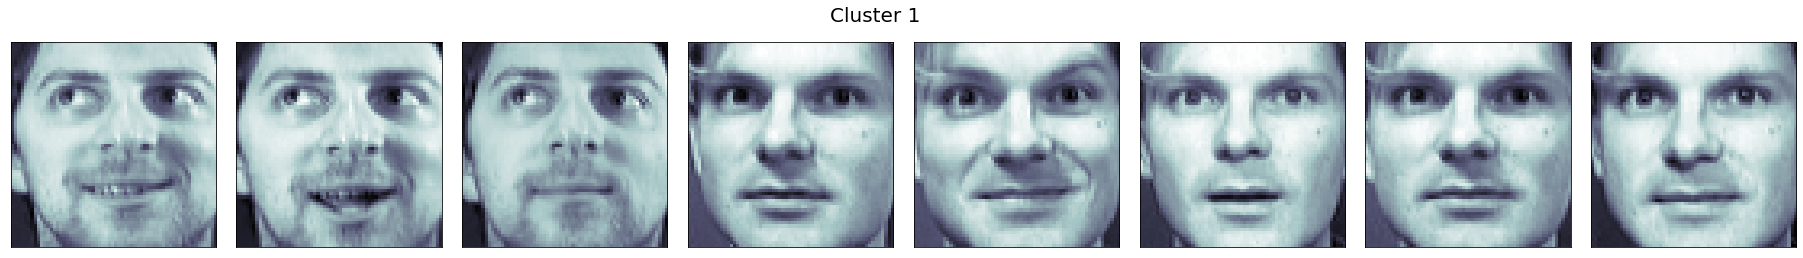

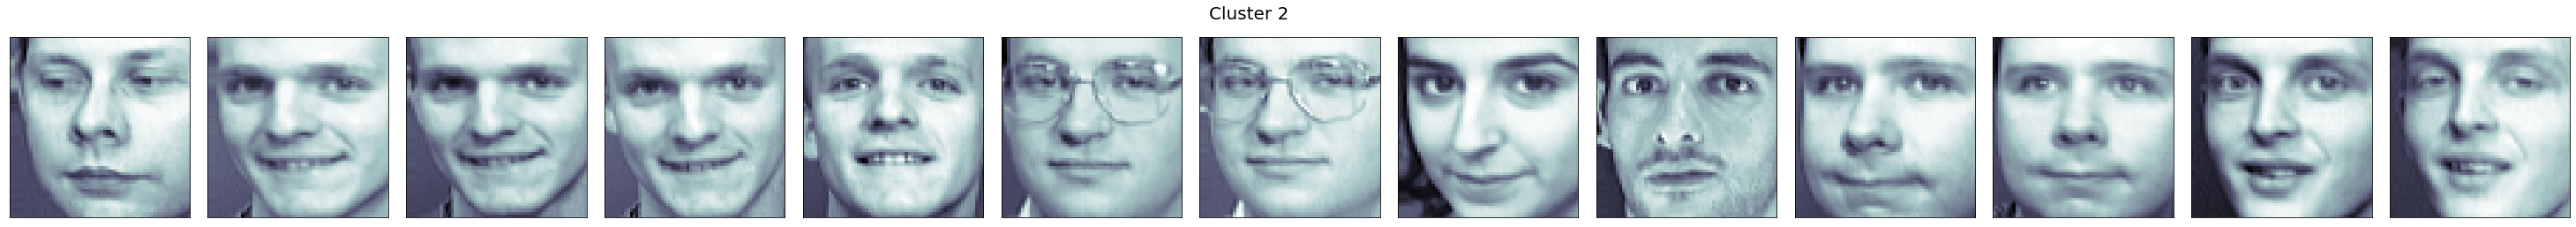

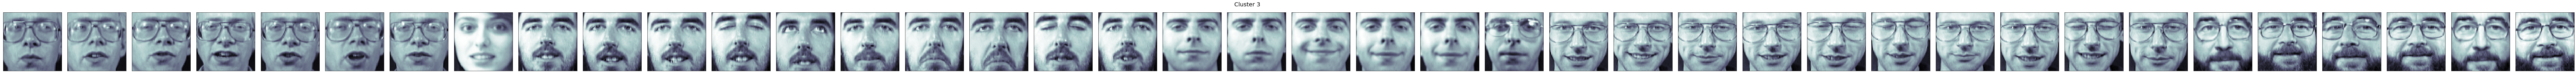

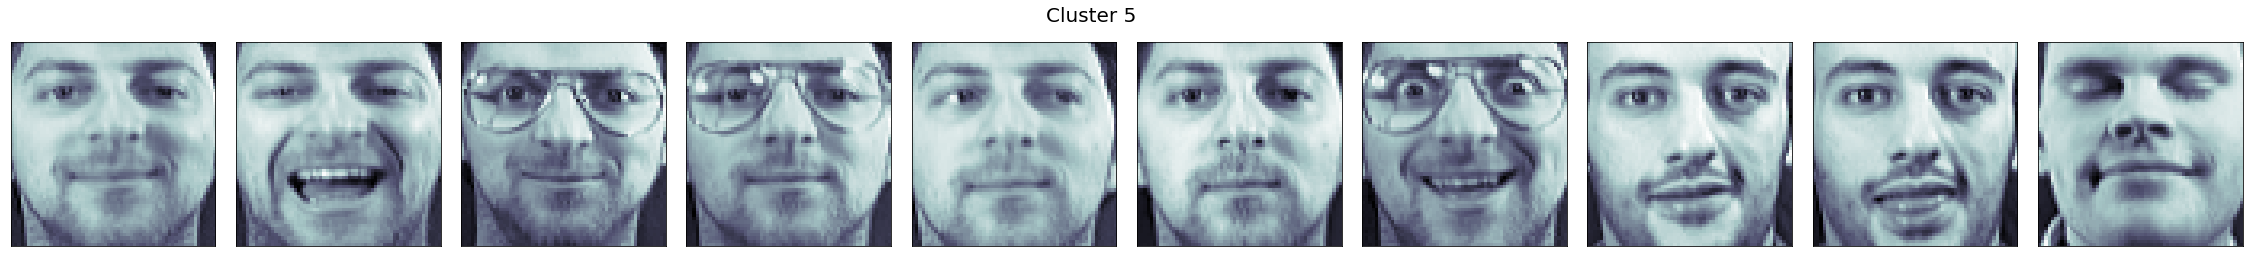

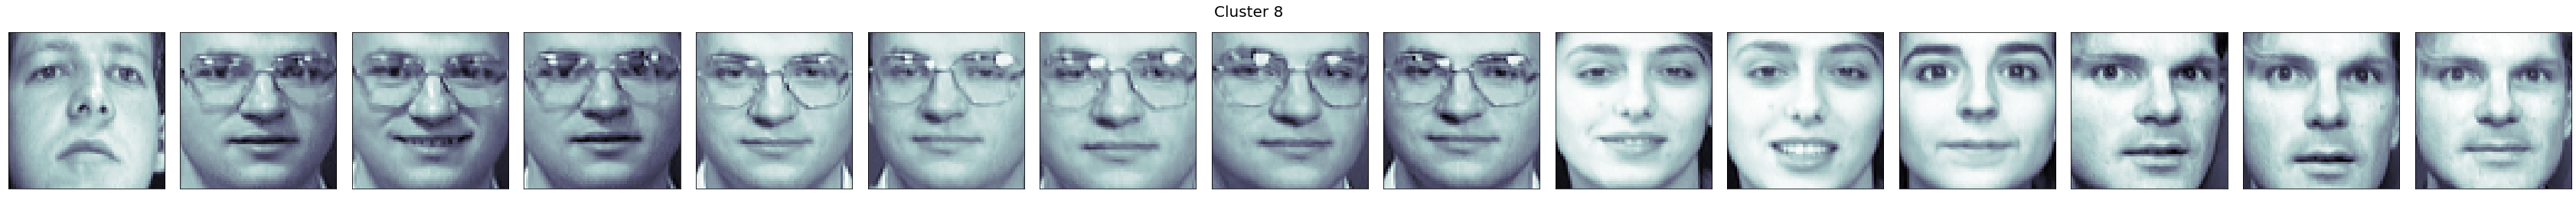

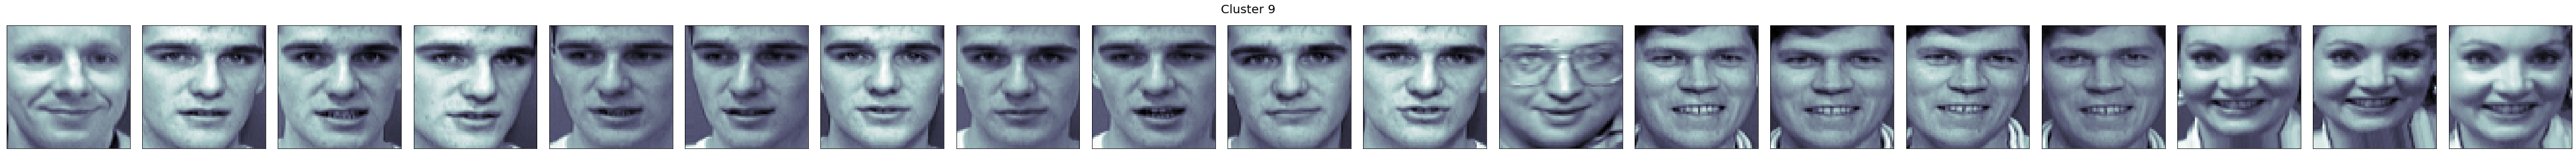

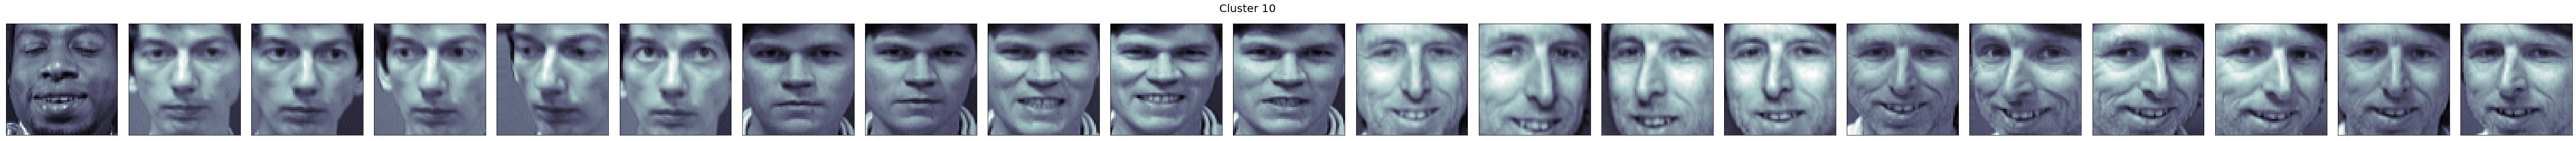

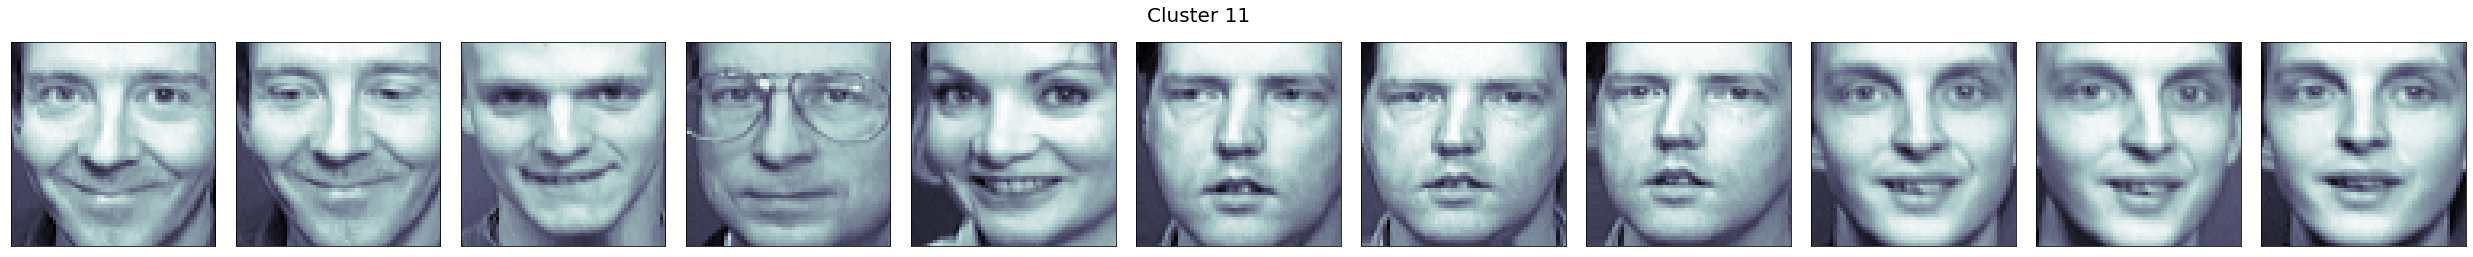

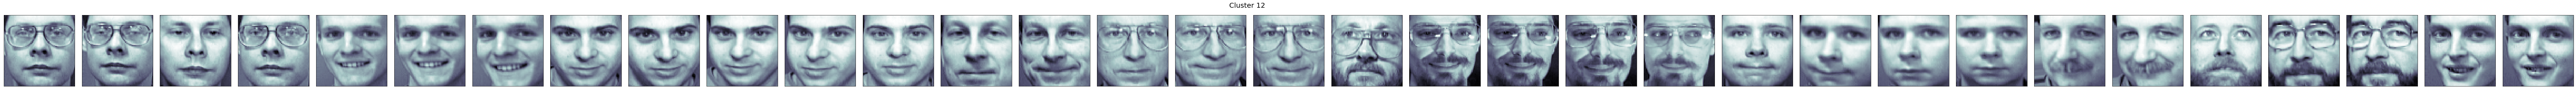

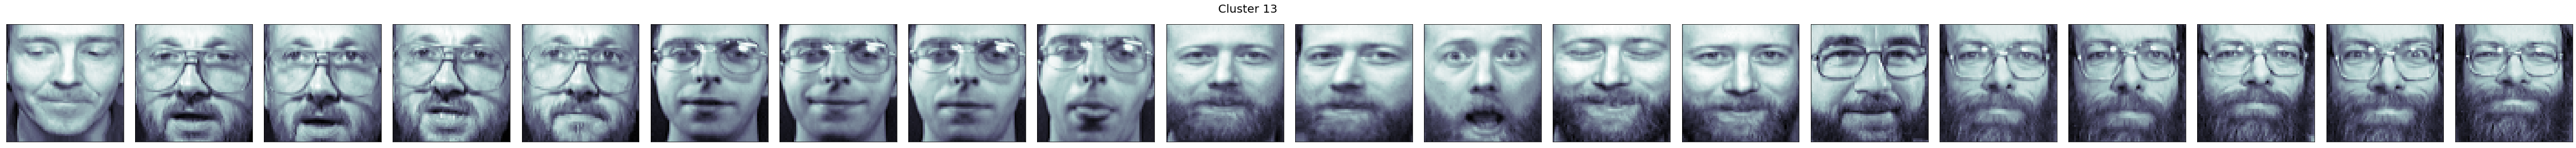

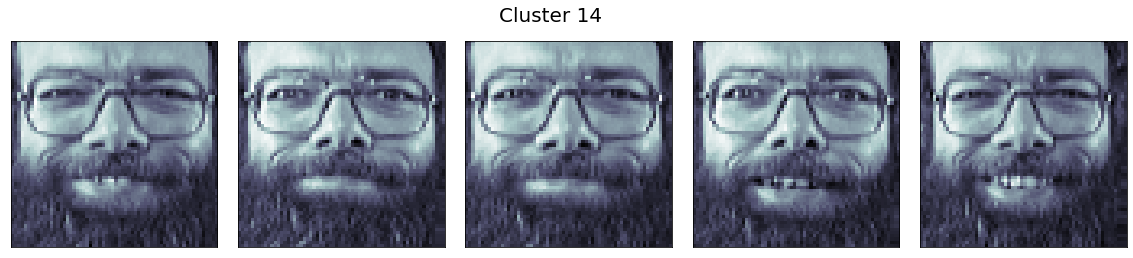

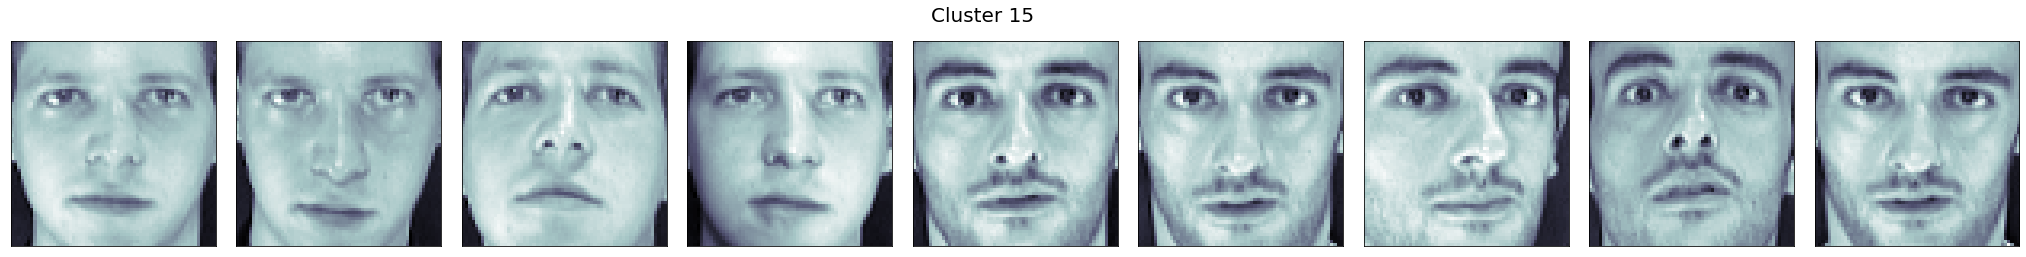

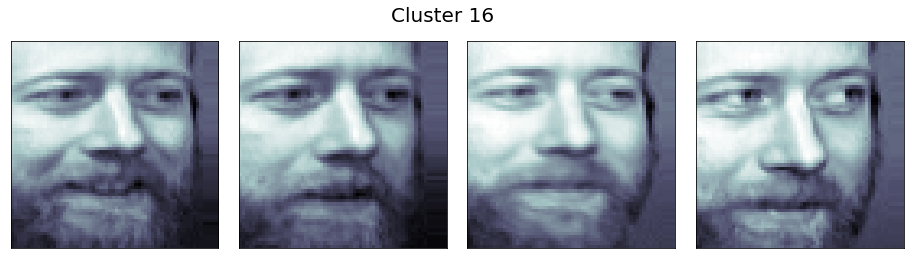

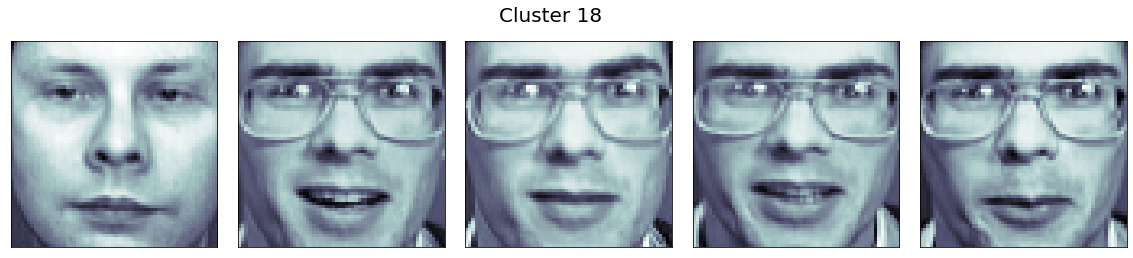

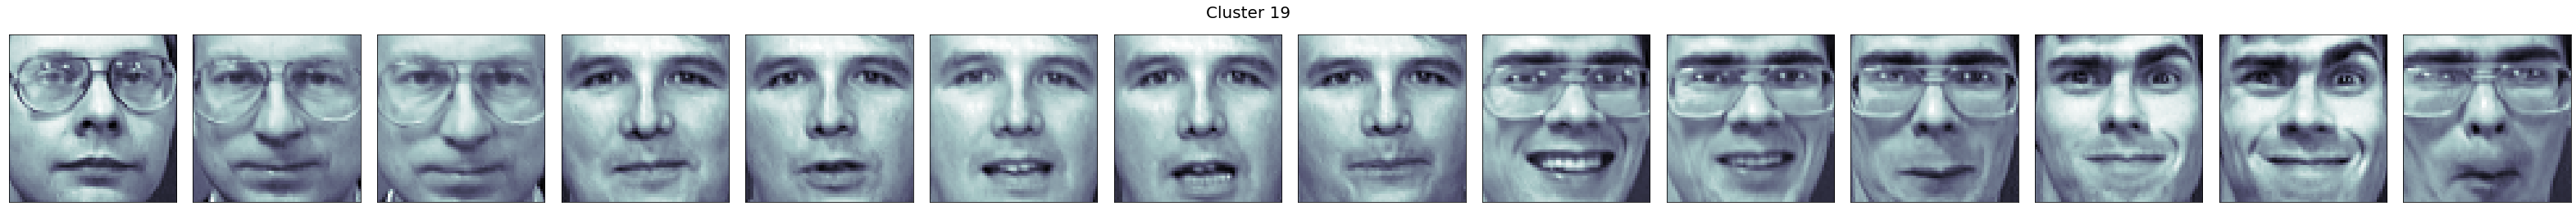

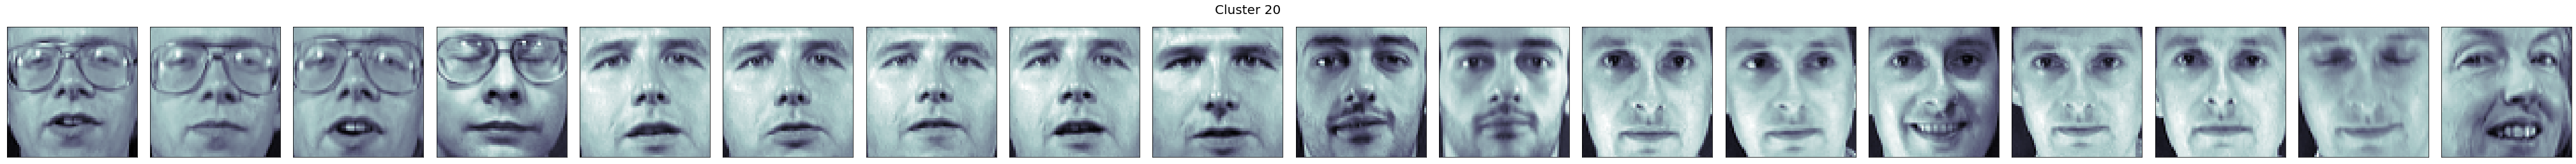

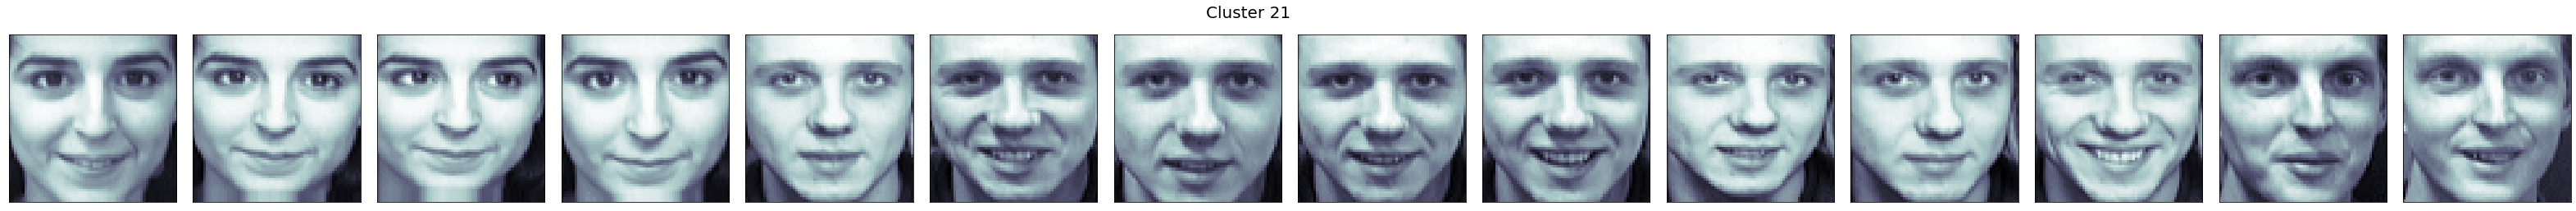

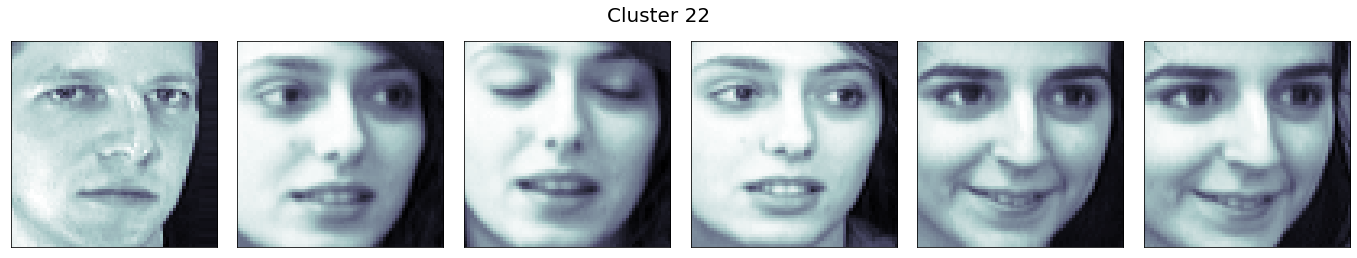

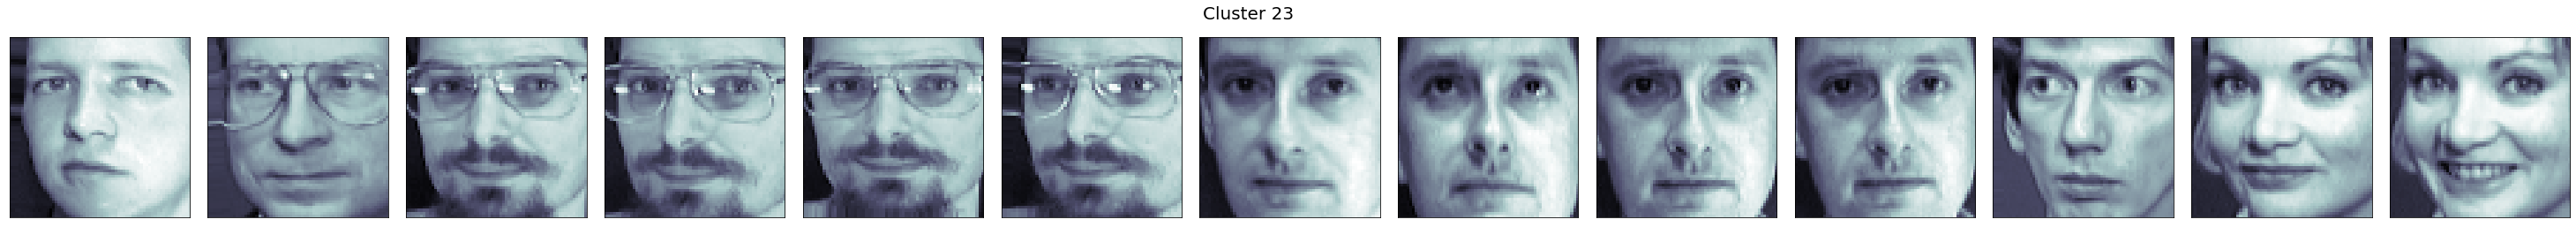

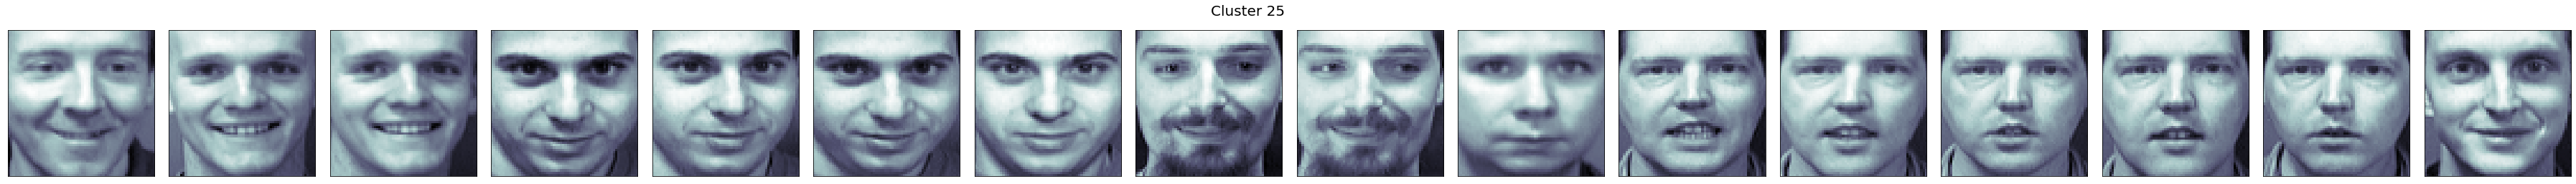

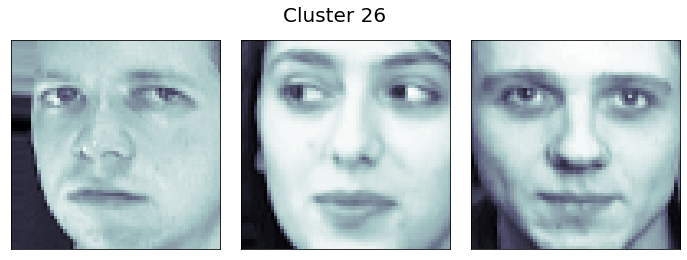

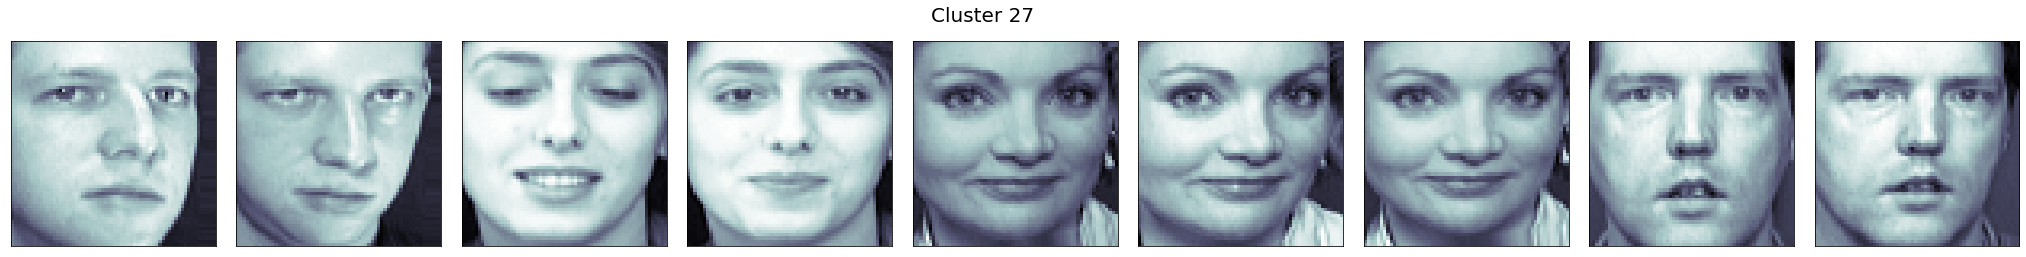

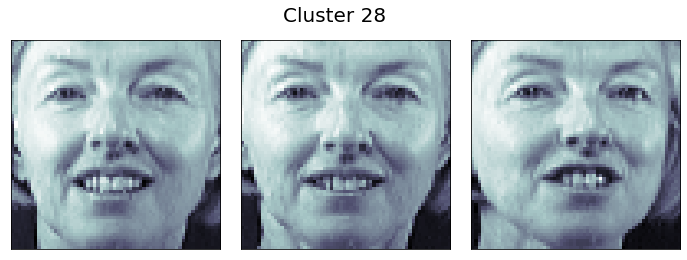

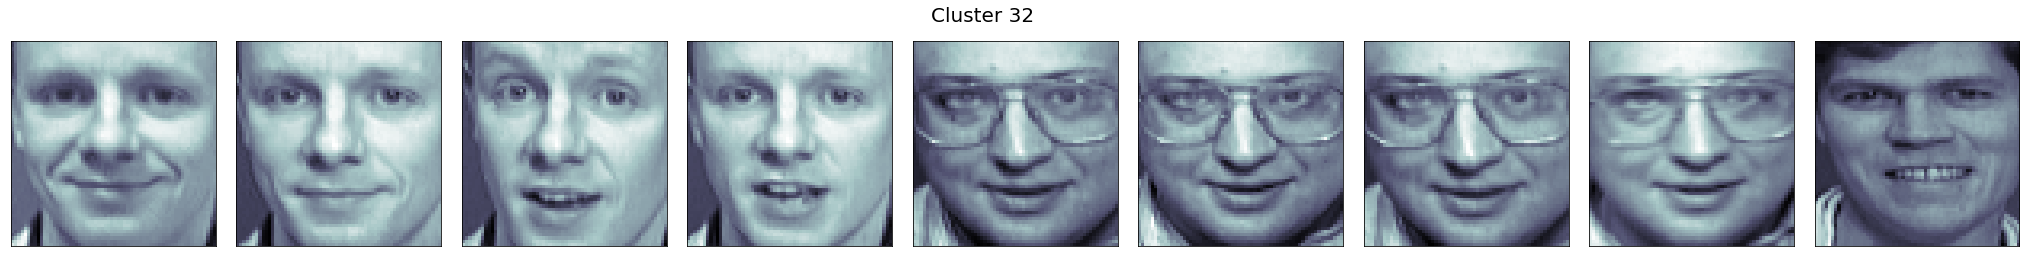

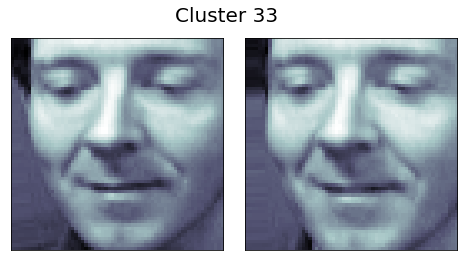

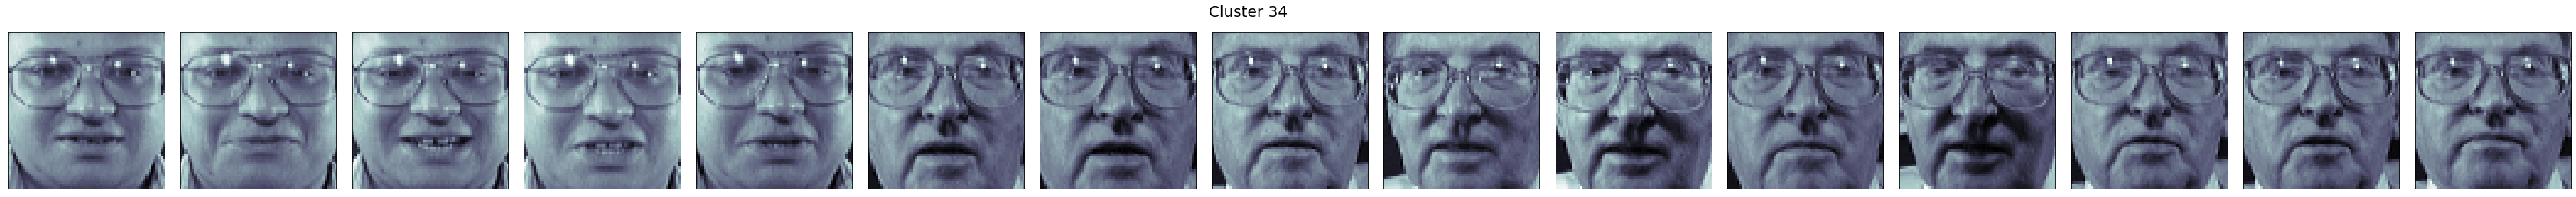

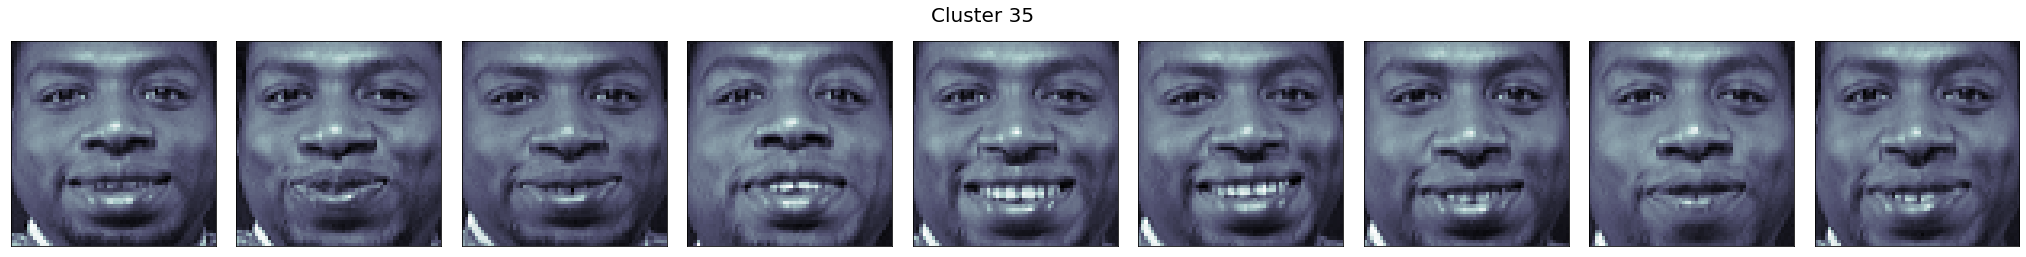

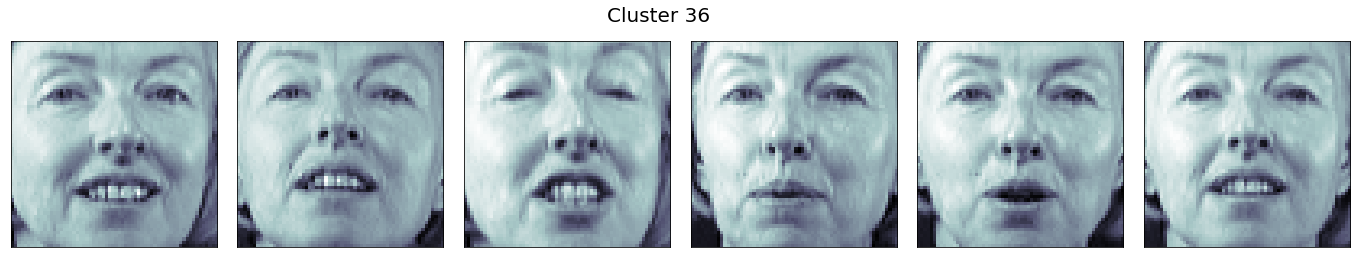

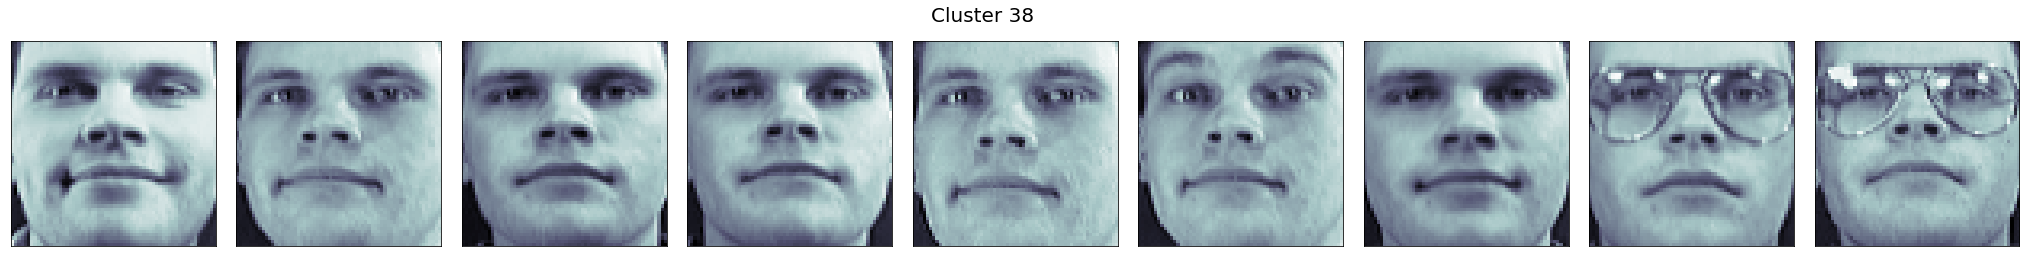

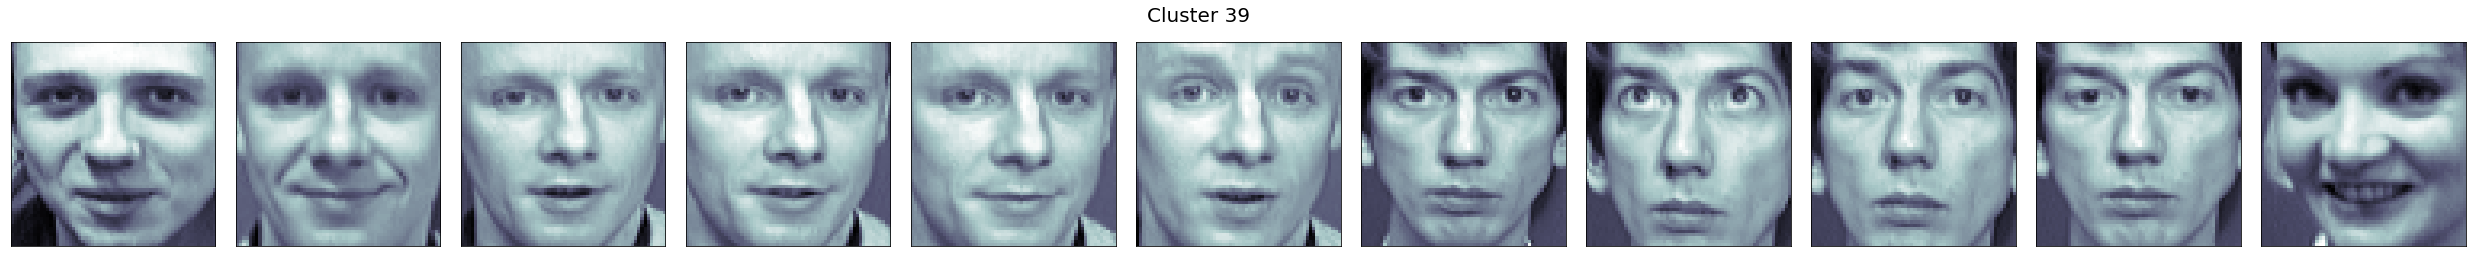

In [5]:
# Implement k-means.
# k = 40, 40张脸，迭代500次
class KMeans():
    def __init__(self, k=40, max_iter=500):
        self.k = k
        self.max_iter = max_iter
        # n * 1 的数组，保存每个样本的 final cluster id
        self.label = None
    
    def _dist(self, a, b):
        '''
        a: 一维数组
        b: 一维数组
        return: 欧几里得距离
        '''
        return np.math.sqrt(sum(np.power(a - b, 2)))
    
    def _randCenter(self, data, k):
        '''
        data: n * m 的样本，其中 n 是样本个数，m 是特征个数
        k: cluster 的个数
        return: 随机选择的 k 个质心
        '''
        m = data.shape[1]
        centers = np.empty((k, m))  # kxm 矩阵保存所有的质心
        for i in range(m):
            minVal = min(data[:, i])
            maxVal = max(data[:, i])
            centers[:, i] = (minVal + (maxVal - minVal) * np.random.rand(k, 1)).flatten()
        return centers
    
        
    def fit(self, data):
        '''
        将输入的data进行聚类，并将聚类结果保存在self.label中
        data: n * m 的样本，其中 n 是样本个数，m 是特征个数
        '''
        n = data.shape[0] # 样本个数
        cluster_assign = np.zeros(n) # 样本分配的 cluster id
        cluster_dis = np.full(n, np.inf) # 样本到 cluster 中心的距离
        
        centers = self._randCenter(data, self.k)
        
        for _ in range(self.max_iter):
            cluster_changed = False
            for i in range(n):
                min_dist = np.inf
                min_index = -1
                # 遍历所有的 cluster 中心，尝试为当前样本分配更近的 cluster
                for j in range(self.k):
                    center = centers[j, :]
                    sample = data[i, :]
                    dis = self._dist(center, sample)
                    if dis < min_dist:
                        min_dist = dis
                        min_index = j
                
                if cluster_assign[i] != min_index and cluster_dis[i] > min_dist:
                    cluster_changed = True
                    cluster_assign[i] = min_index 
                    cluster_dis[i] = min_dist
            # 如果所有样本都没有变化，说明收敛，则退出
            if not cluster_changed:
                break
            
            for i in range(self.k):
                index = np.nonzero(cluster_assign==i)[0]
                centers[i, :] = np.mean(data[index], axis=0)
        
        self.labels = cluster_assign
        
# Clustering
cluster_num = 40
cluster = KMeans(k=cluster_num)
cluster.fit(faces_pca)

# show final results
labels = cluster.labels
for i in range(cluster_num):
    index = np.nonzero(labels==i)[0]
    num = len(index)
    if num == 0:
        continue
    this_faces = faces_image[index]
    fig, axes = plt.subplots(1, num, figsize=(4 * num, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    fig.suptitle("Cluster " + str(i), fontsize=20)
    for i, ax in enumerate(axes.flat):
        ax.imshow(this_faces[i], cmap='bone')